In [3]:
import numpy as np
import matplotlib.pyplot as plt
from lal import MSUN_SI, MTSUN_SI, PC_SI, C_SI, G_SI
from pycbc.waveform import get_td_waveform, get_td_waveform_modes
from pycbc.filter import highpass, lowpass
from pycbc.types import TimeSeries
from sympy.physics.wigner import wigner_3j
import gwmemory
from scipy.fft import fft, fftfreq
from matplotlib import cm
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from gwpy.timeseries import TimeSeries as GWpyTimeSeries
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import PillowWriter

/tmp/ipykernel_1138/4198324317.py:3: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MSUN_SI, MTSUN_SI, PC_SI, C_SI, G_SI
/usr/local/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Figure 1 : Waveforms + Memory (from h_22 mode)

In [4]:
# Calcul du Spin-weighted spherical harmonic modes (l,m)
# Définition sur base de l'article : https://arxiv.org/pdf/0812.0069#page=5.61
def fac(n): # Défini n! 
    if n==0 or n==1:
        return 1
    result = 1
    for i in range(2, n+1):
        result *= i
    return result

def dlms(l, m, s, Theta): # eq (2.14)
    
    sq = np.sqrt(fac(l+m)*fac(l-m)*fac(l+s)*fac(l-s))
    d = 0.
    for k in range(max(0,m-s),min(l+m,l-s)+1):
        d = d + (-1.)**k*np.sin(Theta/2.)**(2.*k+s-m)*np.cos(Theta/2.)**(2.*l+m-s-2.*k)/(fac(k)*fac(l+m-k)*fac(l-s-k)*fac(s-m+k))
    return sq*d

def sYlm(s,l,m,Theta,Phi): # eq (2.13)
    
    res = (-1.)**(-s)*np.sqrt((2.*l+1)/(4*np.pi))*dlms(l,m,-s,Theta)
    
    if res==0:
        return 0
    else:
        return complex(res*np.cos(m*Phi), res*np.sin(m*Phi)) # e^(imPhi)

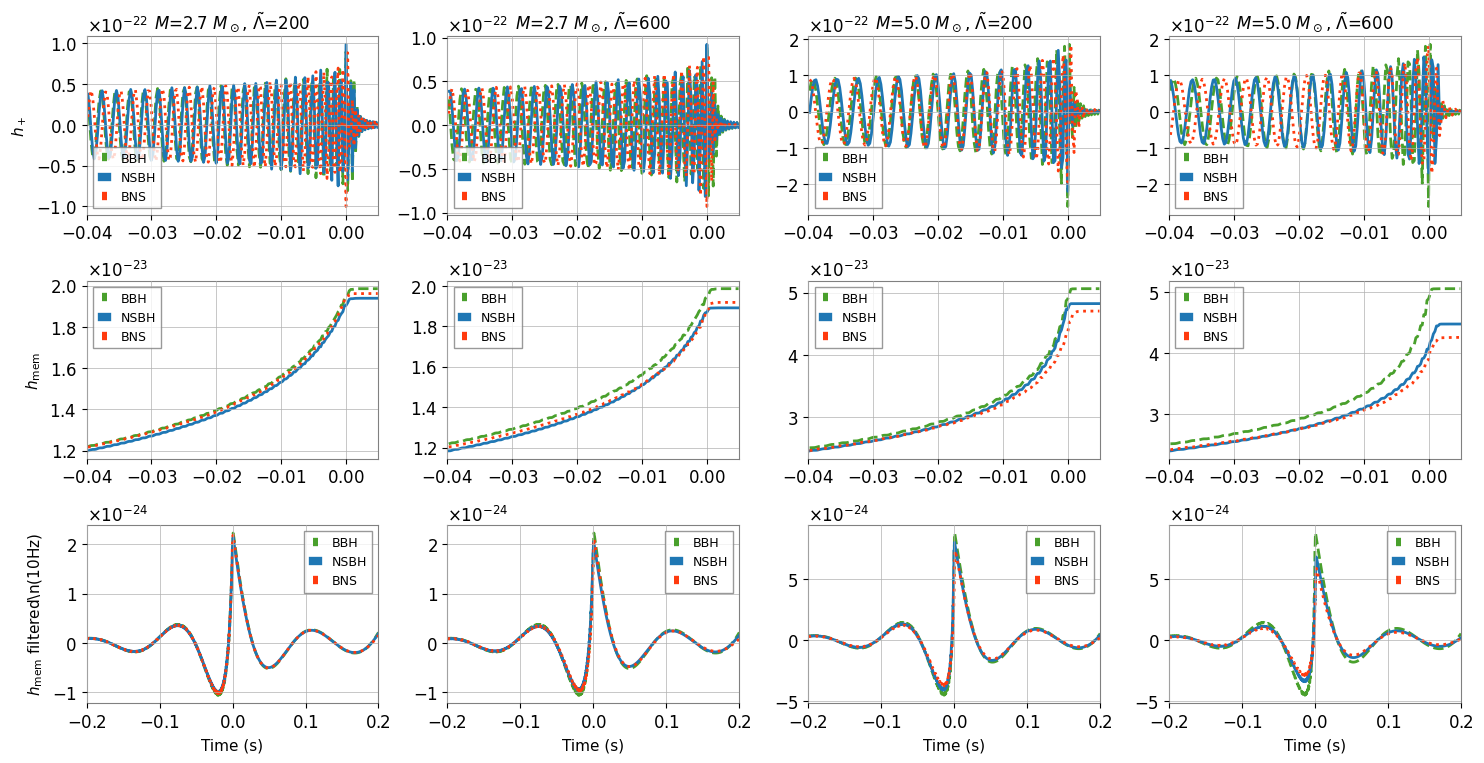

In [5]:
# Constantes 
deltaT = 1.0/4096 # Sample rate
inclination = np.pi/2 # Vue edge-on
distance = 100.0 # Mpc

def generate_waveform_extended(mtot, lam_tilde, system, extension_time=0.2):
    """
    Génère une forme d'onde étendue avec post-merger pour la mémoire
    """
    m1 = m2 = mtot/2.0
    
    if system == "BNS":
        approximant = "SEOBNRv4_ROM_NRTidalv2"
        lambda1 = lambda2 =  lam_tilde
    elif system == "BBH":
        approximant = "SEOBNRv4_ROM_NRTidalv2"
        lambda1 = lambda2 = 0
    elif system == "NSBH":
        approximant = "SEOBNRv4_ROM_NRTidalv2_NSBH"
        lambda1 = 0
        lambda2 = lam_tilde/2 # Correction vu la formule de Lambda_tilde avec lambda_1 = 0
    else:
        raise ValueError(f"Système non reconnu: {system}")

    # Génération sans spécifier tc
    hp, hc = get_td_waveform(
        approximant=approximant,
        mass1=m1, mass2=m2,
        lambda1=lambda1, lambda2=lambda2,
        delta_t=deltaT,
        f_lower=20.,
        distance=distance, 
        inclination=inclination, 
    )
    
    # Conversion en arrays numpy
    hp_orig = hp.numpy()
    hc_orig = hc.numpy()
    
    # Grille temporelle originale
    t_orig = hp.sample_times.numpy()
    
    # ALIGNEMENT MANUEL: trouver le maximum d'amplitude et décaler pour mettre à t=0
    amplitude = np.abs(hp_orig)
    merger_idx = np.argmax(amplitude) # On associe le merger au max 
    merger_time = t_orig[merger_idx]
    
    # Décaler le temps pour mettre le merger à t=0
    t_aligned = t_orig - merger_time
    
    # Extension post-merger
    n_extension = int(extension_time / deltaT)
    hp_extension = np.zeros(n_extension)
    hc_extension = np.zeros(n_extension)
    
    # Temps d'extension
    t_extension = np.arange(1, n_extension + 1) * deltaT + t_aligned[-1]
    
    # Concaténation
    t_extended = np.concatenate([t_aligned, t_extension])
    hp_extended = np.concatenate([hp_orig, hp_extension])
    hc_extended = np.concatenate([hc_orig, hc_extension])
     
    return t_extended, hp_extended, hc_extended

def highpass_filter(h, fcut=10.0, delta_t=1.0/4096):
    """Filtre passe-haut"""
    h_ts = TimeSeries(h, delta_t=delta_t)
    h_highpass = highpass(h_ts, fcut)
    return h_highpass.numpy()

def generate_waveform_22(hp, hc):
    """
    Génère le mode (2,2) à partir de hp et hc
    """
    h22 = (hp - 1.j*hc)/sYlm(-2, 2, 2, inclination, np.pi/2)
    return h22

def compute_memory_corrected(deltaT, h22, distance):
    """
    Mémoire non-linéaire avec normalisation physique correcte
    """
    dt = deltaT
    hdot = np.gradient(h22, dt)
    hdot_c = np.conjugate(hdot)
    integrand = hdot*hdot_c
    cumint = np.cumsum(integrand) * dt
    prefactor = (distance*10**6*PC_SI/C_SI) * (np.sin(inclination))**2 * (17+ np.cos(inclination)**2)/(192*np.pi)
    hmem = prefactor*cumint 
    return np.real(hmem)

# Configuration des styles
styles = {
    'BBH': {'color':  "#49a02c", 'linestyle': 'dashed', 'linewidth': 2, 'label': 'BBH'},
    'BNS': {'color':  "#ff3a0e", 'linestyle': 'dotted', 'linewidth': 2, 'label': 'BNS'},  
    'NSBH': {'color': '#1f77b4', 'linestyle': '-', 'linewidth': 2, 'label': 'NSBH'}
}

# Paramètres 
cases = [
    {"Mtot": 2.7, "lam": 200},
    {"Mtot": 2.7, "lam": 600},
    {"Mtot": 5.0, "lam": 200},
    {"Mtot": 5.0, "lam": 600}
]
systems = ["BBH", "NSBH", "BNS"]

# Plot
fig, axes = plt.subplots(3, 4, figsize=(15, 8))

for j, case in enumerate(cases):
   
    for sys in systems: 
        # Génération
        t_full, hplus_full, hcross_full = generate_waveform_extended(
            case["Mtot"], case["lam"], sys, extension_time=0.2
        )
            
        # Calculs
        h22 = generate_waveform_22(hplus_full, hcross_full)
        hmem = compute_memory_corrected(deltaT, h22, distance)
        hmem_hp = highpass_filter(hmem, fcut=10.0, delta_t=deltaT)
        
        # Style
        style = styles[sys]
        
        # Plots avec masques
        mask_osc = (t_full >= -0.04) & (t_full <= 0.005)
        mask_mem = (t_full >= -0.04) & (t_full <= 0.005)  
        mask_full = (t_full >= -0.2) & (t_full <= 0.2)
        
        axes[0,j].plot(t_full[mask_osc], hplus_full[mask_osc], **style)
        axes[1,j].plot(t_full[mask_mem], hmem[mask_mem], **style)
        axes[2,j].plot(t_full[mask_full], hmem_hp[mask_full], **style)
        
    # Configuration
    axes[0,j].set_title(rf"$M$={case['Mtot']} $M_\odot$, $\tilde{{\Lambda}}$={case['lam']}", fontsize=12)
    axes[0,j].set_xlim(-0.04, 0.005)
    axes[1,j].set_xlim(-0.04, 0.005) 
    axes[2,j].set_xlim(-0.2, 0.2)
    

    
    # Labels
    if j == 0:
        axes[0,j].set_ylabel(r"$h_+$", fontsize=11)
        axes[1,j].set_ylabel(r"$h_{\text{mem}}$", fontsize=11)
        axes[2,j].set_ylabel(r"$h_{\text{mem}}$ filtered\n(10Hz)", fontsize=11)
    
    axes[2,j].set_xlabel("Time (s)", fontsize=11)
    
    for i in range(3):
        if i ==0:
            axes[i, j].legend(fontsize=9, loc='lower left')
        else: 
            axes[i, j].legend(fontsize=9, loc='best')

plt.tight_layout()
plt.show()

Remarques :
- Ordre de grandeur correct pour la waveform et la mémoire MAIS pas parfaitement identique. La mémoire pour NSBH et BNS semble un peu plus grande que dans Lopez et al.

Une autre méthode serait de directement utiliser le mode h20 pour calculer la mémoire. En effet, quand on décompose la waveform en modes sphériques harmoniques, la mémoire est (principalement) contenue dans le mode h20(composante non-oscillante = mémoire). On obtient le mode h20 d'une waveform basée sur un approximant en utilisant la fonction `pycbc.waveform.get_td_waveform`. Seulement, cette méthode ne fonctionne qu'avec certains approximants :


In [6]:
print("Test rapide d'une liste d'approximants compatibles avec get_td_waveform_modes")
print("="*70)

# Approximants à tester
approximants_to_test = [
    "SEOBNRv4", "SEOBNRv2", "IMRPhenomD", "IMRPhenomPv2",
    "SEOBNRv4_ROM_NRTidalv2", "SEOBNRv4_ROM_NRTidalv2_NSBH",
    "IMRPhenomPv2_NRTidal", "IMRPhenomD_NRTidal",
    "TaylorT4", "SpinTaylorT4", "TaylorT2"
]

# Paramètres de test simples
test_params = {
    'mass1': 1.4,
    'mass2': 1.4, 
    'delta_t': 1.0/4096,
    'f_lower': 20.0,
    'distance': 100.0
}

working_approximants = []
failed_approximants = []


for i, approx in enumerate(approximants_to_test):
    try:
        print(f"{i+1:2d}. Test {approx:<30} ... ", end="", flush=True)
        
        # Test simple sans paramètres additionnels
        hlm_dict = get_td_waveform_modes(approximant=approx, **test_params)
        
        n_modes = len(hlm_dict)
        max_l = max([l for l,m in hlm_dict.keys()]) if hlm_dict else 0
        
        print(f"OK: {n_modes:2d} modes (l_max={max_l})")
        working_approximants.append((approx, n_modes, max_l))
        
    except Exception as e:
        error_short = str(e)[:50] + "..." if len(str(e)) > 50 else str(e)
        print(f"Error: {error_short}")
        failed_approximants.append((approx, str(e)))



Test rapide d'une liste d'approximants compatibles avec get_td_waveform_modes
 1. Test SEOBNRv4                       ... Error: I don't support approximant SEOBNRv4, sorry
 2. Test SEOBNRv2                       ... Error: I don't support approximant SEOBNRv2, sorry
 3. Test IMRPhenomD                     ... Error: I don't support approximant IMRPhenomD, sorry
 4. Test IMRPhenomPv2                   ... Error: I don't support approximant IMRPhenomPv2, sorry
 5. Test SEOBNRv4_ROM_NRTidalv2         ... Error: I don't support approximant SEOBNRv4_ROM_NRTidalv2...
 6. Test SEOBNRv4_ROM_NRTidalv2_NSBH    ... Error: I don't support approximant SEOBNRv4_ROM_NRTidalv2...
 7. Test IMRPhenomPv2_NRTidal           ... Error: I don't support approximant IMRPhenomPv2_NRTidal, ...
 8. Test IMRPhenomD_NRTidal             ... Error: I don't support approximant IMRPhenomD_NRTidal, so...
 9. Test TaylorT4                       ... OK: 32 modes (l_max=5)
10. Test SpinTaylorT4                   ... 

XLAL ERROR - XLALSimInspiralChooseTDModes_legacy: maximum l implemented for SpinTaylors is 4, = 5 requested.


OK: 21 modes (l_max=4)
11. Test TaylorT2                       ... OK: 32 modes (l_max=5)


In [7]:
# Voir "Enhancing Gravitational Wave Parameter Estimation with Non-Linear Memory: Breaking the Distance-Inclination Degeneracy" eq (1) et (2)
from sympy.physics.wigner import wigner_3j
def G_ang_int(l1,l2,l3,m1,m2,m3):

	eval = (-1.)**(m1+m2) * np.sqrt(((2.*l1+1.)*(2.*l2+1.)*(2.*l3+1.))/(4.*np.pi)) * wigner_3j(l1,l2,l3,0,2,-2) * wigner_3j(l1,l2,l3,-m1,m2,-m3)

	return float(eval) 
# Fonction principale pour calculer la mémoire pour un mode (l,m) donné
def compute_memory_mode(l, m, h_modes, times, distance):
    """
    Calcule l'amplitude de mémoire pour un mode (l,m) donné
    
    Paramètres:
    -----------
    l, m : int
        Indices du mode de mémoire à calculer
    h_modes : dict
        Dictionnaire des modes {(l', m'): h_l'm'(t)} 
    times : array
        Grille temporelle
    distance : float
        Distance en Mpc
  
    Return:
    ---------
    h_mem_lm : array
        Amplitude de mémoire pour le mode (l,m)
    """
    import numpy as np
    from lal import C_SI, PC_SI
    
    # Constantes
    R = distance * 1e6 * PC_SI  # Convertir Mpc en mètres
    c = C_SI
    dt = times[1] - times[0]
    
    # Préfacteur 
    prefactor = (R / c) * np.sqrt(fac(l - 2) / fac(l + 2))
    
    # Initialisation de l'intégrale
    cumulative_integral = np.zeros(len(times), dtype=complex)
    # Sommes sur tous les modes disponibles
    for (l_prime, m_prime), h_lp_mp in h_modes.items():
        for (l_double_prime, m_double_prime), h_ldp_mdp in h_modes.items():
            
            # Vérification que l', l'' >= 2 (modes physiques)
            if l_prime < 2 or l_double_prime < 2:
                continue
                
            # Calcul de l'intégrale angulaire G
            G_factor = G_ang_int(l, l_prime, l_double_prime, 
                                   m, m_prime, m_double_prime)

            # Dérivées temporelles des modes
            h_dot_lp_mp = np.gradient(h_lp_mp, dt)
            h_dot_ldp_mdp = np.gradient(h_ldp_mdp, dt)
            
            # Intégrand
            intergrand =  G_factor * h_dot_lp_mp * np.conj(h_dot_ldp_mdp)

            # Intégration cumulative de -indini à T_R (temps retardé)
            # On suppose que T_R correspond au temps final de l'observation
            cumulative_integral += np.cumsum(intergrand) * dt
    
    # Résultat final
    h_mem_lm = prefactor  * cumulative_integral
    
    return np.real(h_mem_lm)

# Fonction auxiliaire pour calculer toute la mémoire
def compute_all_memory_modes(hlm_dict, times, distance, max_l):
    """
    Calcule la mémoire pour tous les modes jusqu'à l_max
    
    Paramètres:
    -----------
    hlm_dict : dict
        Modes oscillatoires {(l,m): h_lm des 2 polarisations -> Il faut combiner h = hp - i*hc}
    times : array
        Grille temporelle  
    distance : float
        Distance en Mpc
    max_l : int
        Moment multipolaire maximal à calculer
        
    Retourne:
    ---------
    memory_modes : dict
        Modes de mémoire {(l,m): h_mem_lm}
    """
    # Conversion des modes PyCBC en modes complexes
    h_modes = {}
    for (l, m), (hp, hc) in hlm_dict.items():
        # Combiner hp et hc en mode complexe
        h_modes[(l, m)] = hp- 1j * hc

    memory_modes = {}
    print('ok')
    # Boucle sur tous les modes de mémoire possibles
    for l in range(2, max_l + 1):
        for m in range(-l, l + 1):
            
            h_mem_lm = compute_memory_mode(l, m, h_modes, times, 
                                         distance)

            # Stocker seulement si non-trivial
            memory_modes[(l, m)] = h_mem_lm 
    return memory_modes

In [8]:
test_params = {
    'mass1': 1.35,
    'mass2': 1.35, 
    'delta_t': 1.0/4096,
    'f_lower': 20.0,
    'distance': 100.0,
    'inclination': np.pi/2
}

app = 'TaylorT4'

# Génération des modes
hlm_dict = get_td_waveform_modes(approximant=app, **test_params)

# Redimensionnement des modes pour correspondre à la taille de t_full
for key in hlm_dict:
    hp_mode, hc_mode = hlm_dict[key]
    # Interpolation sur la grille t_full
    hp_interp = np.interp(t_full, hp_mode.sample_times.numpy(), hp_mode.numpy())
    hc_interp = np.interp(t_full, hc_mode.sample_times.numpy(), hc_mode.numpy())
    hlm_dict[key] = (hp_interp, hc_interp)

times = t_full  # Utilisation du même sample que précédemment
# On utilise t_full comme grille temporelle pour la mémoire
memory_modes = compute_all_memory_modes(hlm_dict, t_full, distance=100.0, max_l=4)

ok


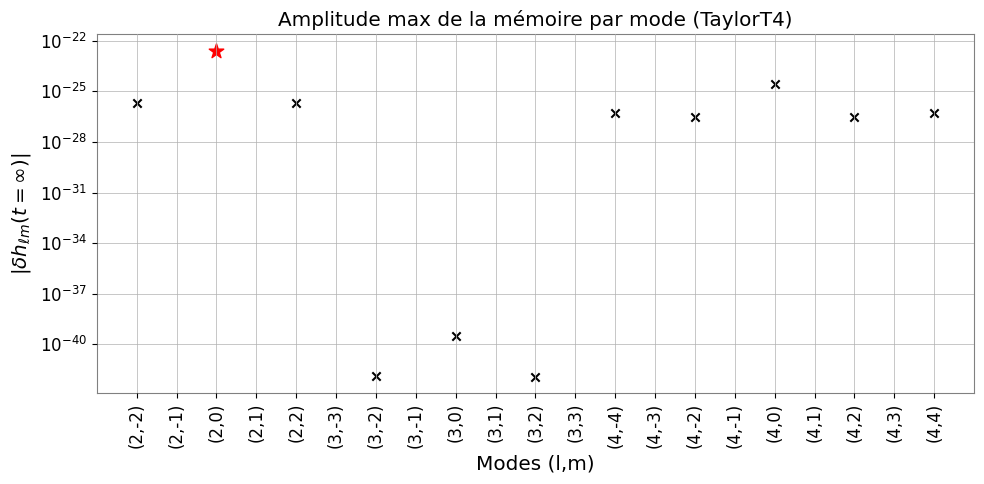

[np.float64(2.0026362431636452e-26), np.float64(0.0), np.float64(2.6178647321556897e-23), np.float64(0.0), np.float64(2.0026362431636452e-26), np.float64(0.0), np.float64(1.3097490882855352e-42), np.float64(0.0), np.float64(3.065561294638601e-40), np.float64(0.0), np.float64(1.1974848807182036e-42), np.float64(0.0), np.float64(5.39476775590214e-27), np.float64(0.0), np.float64(2.8614377034218147e-27), np.float64(0.0), np.float64(2.9064077935252484e-25), np.float64(0.0), np.float64(2.8614377034218147e-27), np.float64(0.0), np.float64(5.39476775590214e-27)]


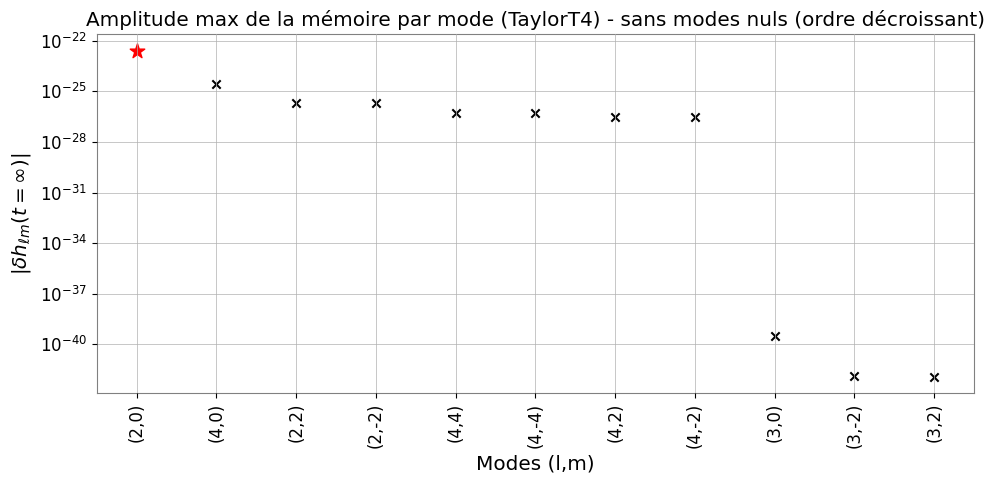

In [9]:
# Extraire les max des effets mémoires pour chaque mode
modes = []
max_memory = []
for (l, m), mem in memory_modes.items():
    modes.append(f"({l},{m})")
    max_memory.append(np.max(np.abs(mem)))

# Scatter plot
plt.figure(figsize=(10, 5))
# Trouver l'indice de la plus grande valeur
max_idx = np.argmax(max_memory)

for i, (mode, mem) in enumerate(zip(modes, max_memory)):
    if i == max_idx:
        plt.scatter(mode, mem, color='r', marker='*', s=120)
    else:
        plt.scatter(mode, mem, color='black', marker='x')


plt.xticks(rotation=90)

plt.xlabel("Modes (l,m)")
plt.ylabel(r"$|\delta h_{\ell m}(t=\infty)|$")
plt.yscale('log')
plt.title("Amplitude max de la mémoire par mode (TaylorT4)")
plt.tight_layout()
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()
print(max_memory)
# Créer un masque pour les modes non nuls
mask_nonzero = np.array(max_memory) != 0
modes_nonzero = np.array(modes)[mask_nonzero]
max_memory_nonzero = np.array(max_memory)[mask_nonzero]

        
# Nouveau plot sans les modes nuls
plt.figure(figsize=(10, 5))
# Trier les modes et amplitudes par ordre décroissant d'amplitude
sorted_indices = np.argsort(max_memory_nonzero)[::-1]
modes_sorted = modes_nonzero[sorted_indices]
max_memory_sorted = max_memory_nonzero[sorted_indices]


for i, (mode, mem) in enumerate(zip(modes_sorted, max_memory_sorted)):
    if i == 0:
        plt.scatter(mode, mem, color='r', marker='*', s=120)
    else:
        plt.scatter(mode, mem, color='black', marker='x')

plt.xticks(rotation=90)
plt.xlabel("Modes (l,m)")
plt.ylabel(r"$|\delta h_{\ell m}(t=\infty)|$")
plt.yscale('log')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.title("Amplitude max de la mémoire par mode (TaylorT4) - sans modes nuls (ordre décroissant)")
plt.tight_layout()
plt.show()

Comme attendu, le mode (2,0) domine pour l'effet mémoire comme mentionné dans plusieurs articles. Par ailleurs, on pourrait comparer les amplitudes des modes et non de l'effet mémoire induit par ces modes 

On peut comparer la mémoire calculé juste avec ``get_td_waveform_modes`` et avec la formule précédente

In [10]:
# Mémoire pour le mode (2,0)
h20_mem = memory_modes.get((2,0), None)

# Calcul de la mémoire en sommant tous les modes - normalement négligeable par rapport à (2,0)
hmem_total = np.zeros_like(times)
for mem in memory_modes.values():
    hmem_total += mem
    

In [11]:
# Calcul de l'effet mémoire sur base de la méthode simple du mode (2,2)
sys = "BNS"
distance = 100.0
deltaT = 1.0/4096
t_full, hplus_full, hcross_full = generate_waveform_extended(
            2.7, 0, sys, extension_time=0.2)
h22_old = generate_waveform_22(hplus_full, hcross_full)
hmem_old = compute_memory_corrected(deltaT, h22_old, distance)

# Idem mais on utilise le mode (2,2) de la méthode get_td_waveform_modes
h22_new = hlm_dict.get((2,2), (None, None))[0] - 1j*hlm_dict.get((2,2), (None, None))[1]
hmem_new = compute_memory_corrected(deltaT, h22_new, distance)

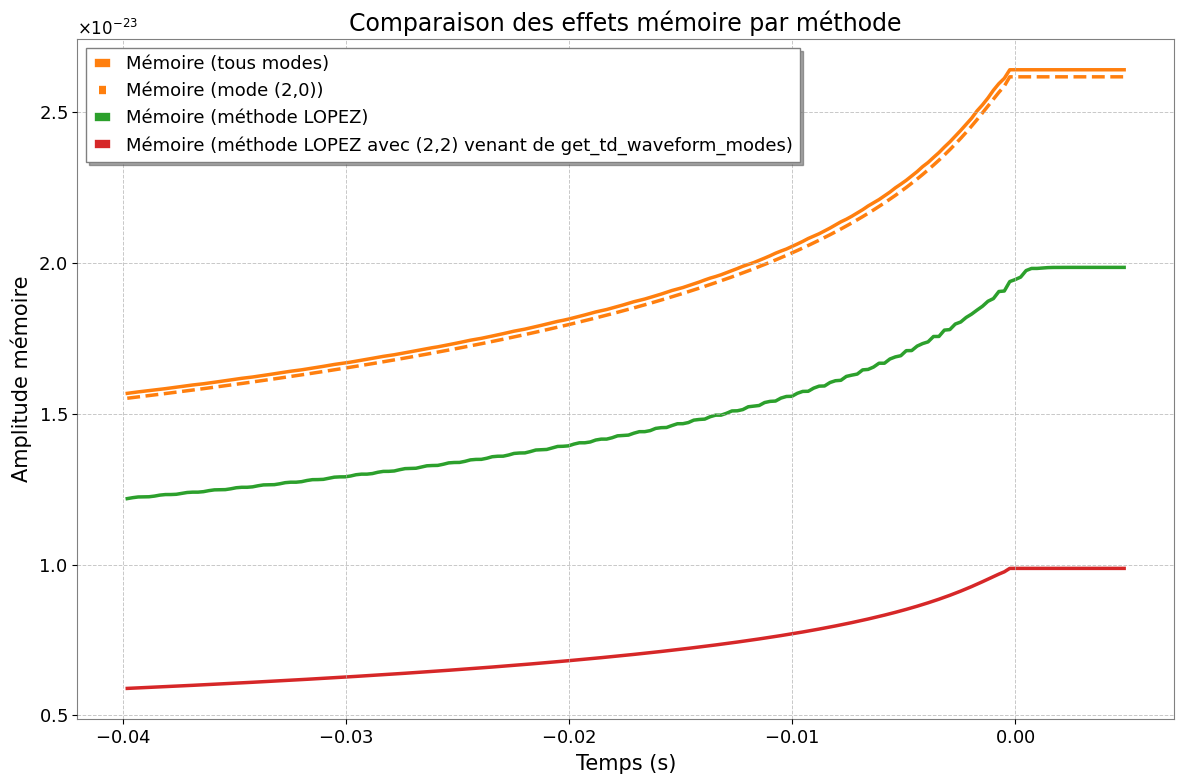

In [15]:
plt.figure(figsize=(12, 8))

# Masques pour la partie avant merger
mask = (times >= -0.04) & (times <= 0.005)
mask_full = (t_full >= -0.04) & (t_full <= 0.005)

# Tracé avec couleurs et styles améliorés
plt.plot(times[mask], hmem_total[mask], label="Mémoire (tous modes)", linestyle='-', color='#ff7f0e', linewidth=2.5)
plt.plot(times[mask], h20_mem[mask], label="Mémoire (mode (2,0))", linestyle='--', color='#ff7f0e', linewidth=2.5)
plt.plot(t_full[mask_full], hmem_old[mask_full], label="Mémoire (méthode LOPEZ)", linestyle='-', color='#2ca02c', linewidth=2.5)
plt.plot(times[mask], hmem_new[mask], label="Mémoire (méthode LOPEZ avec (2,2) venant de get_td_waveform_modes)", linestyle='-', color='#d62728', linewidth=2.5)

plt.legend(fontsize=13, loc='upper left', frameon=True, shadow=True)
plt.xlabel("Temps (s)", fontsize=15)
plt.ylabel("Amplitude mémoire", fontsize=15)
plt.title("Comparaison des effets mémoire par méthode", fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()

Une autre méthode pour calculer la mémoire serait d'utiliser la library `GWMemory`  

In [ ]:
# Installons les différents approximants disponibles
approximants = [
    "SEOBNRv4", "NRsur7dq2", "MWM", "NRHybSur3dq8", "IMRPhenomD"]
for approx in approximants:
    %pip install approx
# Il n'existe que 5 apprixmants dans GWmemory - voir doc 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Model NRsur7dq2 unknown


TypeError: cannot unpack non-iterable NoneType object

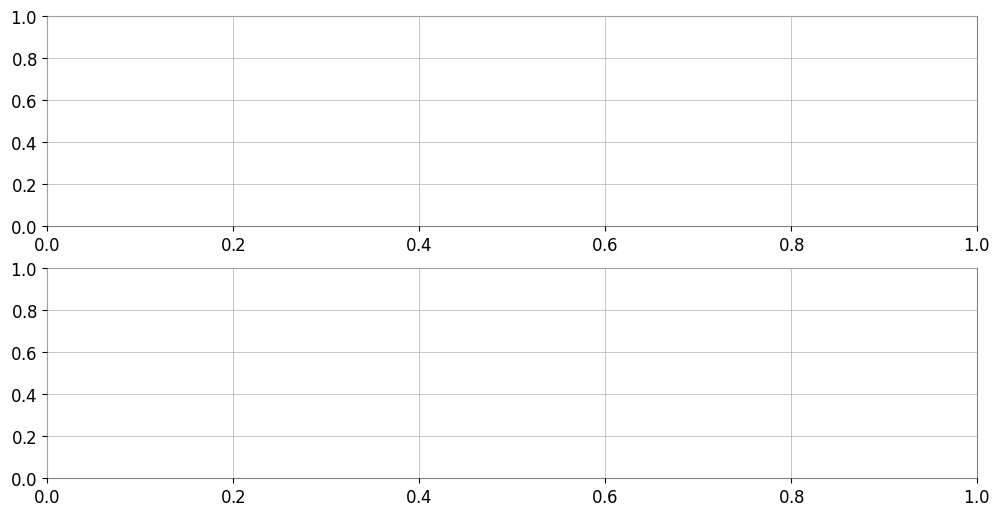

In [18]:
fig = plt.figure(figsize=(12, 6))
ax = [fig.add_subplot(2, 1, 1), fig.add_subplot(2, 1, 2)]
# Paramètres communs
total_mass = 60          # Masse totale (M_sun)
distance = 100           # Distance (Mpc)
inc = np.pi / 2          # Inclinaison (face-on)
phase = 0                # Phase initiale
q = 1.0                  # Rapport de masse
spin_1 = [0.0, 0.0, 0.0] # Spin du premier objet
spin_2 = [0.0, 0.0, 0.0] # Spin du second objet
times = np.linspace(-0.08, 0.02, 10001)

models = ["NRsur7dq2", "SEOBNRv4", "IMRPhenomD", "MWM"]

colours = ['#1f77b4', "#b104eb", '#2ca02c', '#d62728']

for model, colour in zip(models, colours):
    parameters = dict(
        total_mass=total_mass, distance=distance, model=model,
        inc=inc, phase=phase, times=times, q=q,
        spin_1=spin_1, spin_2=spin_2
    )
    h_mem, times_out = gwmemory.time_domain_memory(**parameters)
    ax[0].plot(times_out, h_mem["plus"] * 1e22, color=colour, linestyle='-', label=f"{model} ")
    ax[1].plot(times_out, h_mem["cross"] * 1e22, color=colour, linestyle='--', label=f"{model}")

ax[0].set_xlabel("$t$ (s)")
ax[0].set_ylabel("$\delta h_{+} \\, [10^{-22}]$")
ax[0].set_title("Mémoire gravitationnelle $h_+$")
ax[0].set_xlim(-0.02, 0.02)
ax[0].legend(fontsize=10)


ax[1].set_xlabel("$t$ (s)")
ax[1].set_ylabel("$\delta h_{\\times} \\, [10^{-22}]$")
ax[1].set_title("Mémoire gravitationnelle $h_\\times$")
ax[1].set_xlim(-0.02, 0.02)
ax[1].legend(fontsize=10)


plt.tight_layout()
plt.show()


Chaque model donne une mémoire différente, il serait intéressant de comparer les modèles et voir lequel est le plus approprié pour la mémoire de BNS

On peut aussi comparer l'importance de chaque mode pour l'effet mémoire

In [ ]:
fig = plt.figure(figsize=(12, 6))

# Configuration unique fixe
times = np.linspace(-0.08, 0.02, 10001)
parameters_base = dict(
    total_mass=60,           # Masse totale (M_sun)
    distance=400,           # Distance (Mpc)
    inc=np.pi / 2,          # Inclinaison (face-on)
    q=1.0,                  # Rapport de masse
    spin_1=[0.0, 0.0, 0.0], # Spin du premier objet
    spin_2=[0.0, 0.0, 0.0], # Spin du second objet
    times=times
)

# Modèles et couleurs
models = ["NRSur7dq2", "SEOBNRv4", "IMRPhenomD", "MWM"]
colours = ['#1f77b4', '#b104eb', '#2ca02c', '#d62728']


# Calcul et plot pour chaque modèle
for i, (model, colour) in enumerate(zip(models, colours)):
    parameters = parameters_base.copy()
    parameters["model"] = model
    
    try:
        h_mem, _ = gwmemory.time_domain_memory(**parameters)
        
        # Collecter les modes et amplitudes pour ce modèle
        mode_positions = []
        amplitudes = []
        mode_labels = []
        
        for ell, delta_m in h_mem:
            if ell <= 4:
                x_pos = ell**2 + delta_m + ell
                amplitude = abs(h_mem[(ell, delta_m)][-1])
                
                mode_positions.append(x_pos)
                amplitudes.append(amplitude)
                mode_labels.append(f"({ell},{delta_m})")
        
        # Scatter plot pour ce modèle
        plt.scatter(
            mode_positions, amplitudes,
            marker='x', s=120,
            color=colour,
            label=f"{model}",
            alpha=1,
            zorder=5 - i  # Pour superposer les modèles dans l'ordre
        )
                
    except Exception as e:
        print(f"Erreur avec le modèle {model}: {e}")

# Configuration du plot
plt.xlim(3, 5**2)
plt.xticks(range(4, 5**2, 1), rotation=270)

# Génération des étiquettes des modes
try:
    keys = [f"({ell}, {delta_m})" for ell, delta_m in gwmemory.harmonics.lmax_modes(4)]
    ax = plt.gca()
    ax.set_xticklabels(keys)
except:
    pass

plt.xlabel("Memory modes $(\ell, m)$", fontsize=12)
plt.ylabel("$|\delta h_{\ell m}(t=\infty)|$", fontsize=12)

plt.yscale("log")
plt.ylim(1e-27, 1e-21)

# Configuration de l'axe y
ax = plt.gca()
ax.set_yticks(np.logspace(-27, -21, 7))


# Légende et titre
plt.legend(fontsize=11, loc='upper right', frameon=True, shadow=True)
plt.title("Comparaison des amplitudes de mémoire par mode" )

plt.tight_layout()
plt.show()

On remarque encore une fois que le mode (2,0) domine largement l'effet mémoire pour chacun des modèles, on peut donc se contenter de ce mode pour approximer l'effet mémoire.

In [ ]:
parameters = dict(
    total_mass=5,           # Masse totale (M_sun)
    distance=100,           # Distance (Mpc)
    inc=np.pi / 2,          # Inclinaison (face-on)
    q=1.0,                  # Rapport de masse
    phase = 0,                # Phase initiale - sinon renvoit les modes
    spin_1=[0.0, 0.0, 0.0], # Spin du premier objet
    spin_2=[0.0, 0.0, 0.0], # Spin du second objet
    times=  np.linspace(-0.08, 0.02, 10001),
    model = "IMRPhenomD"
)

# Test appliquer un filtre passe bas pour la mémoire
from pycbc.filter import highpass, lowpass

plt.figure(figsize=(12, 6))
cutoff_freq_test = np.arange(1, 31, 10)
fs = 1.0 / (times[1] - times[0])  # Fréquence d'échantillonnage

# Appliquer le filtre à chaque mode et tracer
h_mem, t = gwmemory.time_domain_memory(**parameters)
print(h_mem.keys())
plt.plot(t, h_mem['plus'] * 1e22, label="Sans filtrage", color='black', linestyle='-', linewidth=3, zorder = 10)
# Conversion en TimeSeries pour le filtrage
mem_ts = TimeSeries(h_mem['plus'], delta_t=t[1] - t[0])
for cutoff in cutoff_freq_test:
    
    mem_filtered = highpass(mem_ts, cutoff)
    
    plt.plot(t, mem_filtered.numpy() * 1e22, label=f"{cutoff} Hz")

    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude mémoire filtrée")
    plt.title("Mémoire gravitationnelle filtrée")
    plt.xlim(-0.02, 0.02)
    plt.legend(fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha =0.7)
    plt.tight_layout()
plt.show()

In [ ]:
# Appliquons une FFT pour voir le contenu fréquentiel
from scipy.fft import fft, fftfreq
plt.figure(figsize=(12, 6))

# Filtrage à 10Hz
mem_ts_10Hz = TimeSeries(h_mem['plus'], delta_t=t[1] - t[0])
mem_filtered_10Hz = highpass(mem_ts_10Hz, 10.0)
# Calcul de la FFT et plot 
for label, h_data in [("Sans filtrage", h_mem['plus']), ("Filtré 10Hz", mem_filtered_10Hz.numpy())]:
    N = len(t)
    T = t[1] - t[0]
    yf = fft(h_data)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label=label)

plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1e3)
plt.ylim(1e-25, 1e-21)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude FFT")
plt.title("Contenu fréquentiel de la mémoire gravitationnelle")
plt.legend(fontsize=10)
plt.show()


Montrer que la mémoire se voit comme un burst sur un spectrogramme:

In [ ]:
def plot_memory_analysis(total_mass, model):
    """
    Analyse l'effet mémoire gravitationnelle avec spectrogramme
    Layout: 2x2 grid
    - Top row: Memory signals (raw left, filtered right)
    - Bottom row: Spectrograms (raw left, filtered right)
    
    Parameters:
    -----------
    model : str
        Modèle d'approximant à utiliser 
    total_mass : float
        Masse totale du système binaire (M_sun)
    """
    
    # Configuration des paramètres avec une grille temporelle adaptée
    times = np.linspace(-10, 10, 5001) # 10s avant et après le merger
    
    parameters = dict(
        total_mass=total_mass,
        distance=100,
        inc=np.pi / 2,
        q=1.0,
        phase=0,
        spin_1=[0.0, 0.0, 0.0],
        spin_2=[0.0, 0.0, 0.0],
        times=times,
        model=model
    )
    
    try:
        # Calcul de l'effet mémoire
        h_mem, t = gwmemory.time_domain_memory(**parameters)
        
        # Vérifications
        if len(h_mem['plus']) == 0 or np.all(h_mem['plus'] == 0):
            print(f"Erreur: L'effet mémoire est vide ou nul pour {model}")
            return
        
        # Conversion en GWpy TimeSeries pour les spectrogrammes
        dt = t[1] - t[0]
        mem_gwpy = GWpyTimeSeries(h_mem['plus'], dt=dt, t0=t[0])
        
        # Filtrage avec PyCBC 
        mem_pycbc = PyCBCTimeSeries(h_mem['plus'], delta_t=dt)
        mem_filtered_pycbc = highpass(mem_pycbc, 10.0)
        
        # Conversion du signal filtré en GWpy TimeSeries
        mem_filtered_gwpy = GWpyTimeSeries(mem_filtered_pycbc.numpy(), 
                                          dt=dt, t0=t[0])
        
        # Configuration de la figure 
        fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex='col', sharey=False)
        fig.suptitle(f' Memory analysis - {model} (M={total_mass} $M_\odot$)', 
                     y=0.98, fontsize=16, weight='bold')
        
        # Première lignes : Sinaux mémoires brut et filtré
        ax_raw = axes[0, 0]
        ax_raw.plot(t, h_mem['plus'] , 'b-', linewidth=2)
        ax_raw.set_xlabel('Time (s)')
        ax_raw.set_ylabel('Amplitude')
        ax_raw.set_title('Mémoire  (brute)')
        ax_raw.grid(True, alpha=0.3)
        textstr = (f'$M_{{tot}}$ = {total_mass} M$_\odot$\n'
                   f'$q$ = {parameters["q"]}\n'
                   f'Distance = {parameters["distance"]} Mpc')
        ax_raw.text(0.02, 0.98, textstr, transform=ax_raw.transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.8))
        
        ax_filt = axes[0, 1]
        ax_filt.plot(t, mem_filtered_pycbc.numpy() , 'r-', linewidth=2)
        ax_filt.set_xlabel('Time (s)')
        ax_filt.set_ylabel('Amplitude')
        ax_filt.set_title('Memory (filtered 10Hz)')
        ax_filt.grid(True, alpha=0.3)

        # 2 eme ligne : Spectrogrammes
        try:
            ax_spec_raw = axes[1, 0]
            specgram_raw = mem_gwpy.spectrogram2(fftlength=1.5, overlap=0, window=None)**(1/2.) # Sans overlap ni window pour simplifier (le signal est pur)
            clim_min_raw = np.percentile(specgram_raw.value, 5)
            clim_max_raw = np.percentile(specgram_raw.value, 99)
            im1 = ax_spec_raw.imshow(
                np.swapaxes(specgram_raw.value, 0, 1),
                aspect='auto',
                origin='lower',
                cmap='hot',
                extent=[
                    specgram_raw.times.value[0], 
                    t[-1],
                    specgram_raw.frequencies.value[0], 
                    specgram_raw.frequencies.value[-1]
                ],
                vmin=clim_min_raw,
                vmax=clim_max_raw
            )
            ax_spec_raw.set_yscale('log')
            ax_spec_raw.set_ylabel('Frequency (Hz)')
            ax_spec_raw.set_xlabel('Time (s)')
            ax_spec_raw.set_title('Spectrogram - Raw signal')
            ax_spec_raw.set_ylim(1, specgram_raw.frequencies.value[-1])
            
            ax_spec_filt = axes[1, 1]
            specgram_filt = mem_filtered_gwpy.spectrogram2(fftlength=1.5, overlap=0, window=None)**(1/2.)
            clim_min_filt = np.percentile(specgram_filt.value, 5)
            clim_max_filt = np.percentile(specgram_filt.value, 99)
            im2 = ax_spec_filt.imshow(
                np.swapaxes(specgram_filt.value, 0, 1),
                aspect='auto',
                origin='lower',
                cmap='hot',
                extent=[
                    specgram_filt.times.value[0], 
                    t[-1],
                    specgram_filt.frequencies.value[0], 
                    specgram_filt.frequencies.value[-1]
                ],
                vmin=clim_min_filt,
                vmax=clim_max_filt
            )
            ax_spec_filt.set_yscale('log')
            ax_spec_filt.set_ylabel('Fréquence (Hz)')
            ax_spec_filt.set_xlabel('Temps (s)')
            ax_spec_filt.set_title('Spectrogram - Filtered signal (10Hz)')
            ax_spec_filt.set_ylim(10, specgram_filt.frequencies.value[-1])
            
            # Colorbar commune pour les spectrogrammes
            ax_spec_filt.colorbar(clim = (clim_min_filt, clim_max_filt), label =r'Amplitude [$1/\sqrt{\mathrm{Hz}}$]')
                
        except Exception as spec_error:
            print(f"Erreur spectrogramme: {spec_error}")

        plt.tight_layout(rect=[0, 0, 0.97, 0.97])
        plt.show()
        
    except Exception as e:
        print(f"Erreur lors de l'analyse du modèle {model}: {e}")

# Exécution
plot_memory_analysis(total_mass = 2.5, model="NRSur7dq2")


Remarque : 
- La mémoire calculée avec gwmemory est plus base que celle dans l'article (10**-27 contre 10**-23). Cela peut venir des paramètres utilisés (distance, masses, spins, inclinaison, ...) et du modèle ?
- On observe bien que la mémoire est un signal DC (basse fréquence) et qu'elle augmente au fur et à mesure de l'évolution du signal principal. 
- La mémoire est semblable à un burst (centré sur le merger) dans le spectrogramme

Piste d'amélioration et de réflexion :
- Injecter la mémoire dans un signal (ajout de la mémoire au signal principal) et voir si on peut la récupérer avec des méthodes de stacking
- Comparer les différentes méthodes de calcul de la mémoire (get_td_waveform_modes, gwmemory, autres ?) et voir sur le spectrogramme ?


# Reproduction plot figure 2 de l'article Lopez

On modifie un peu la fonction qui génère la mémoire pour pourvoir modif certain paramètres (mass ration, distance, inclinaiso)

In [19]:
# fonction qui renvoit lambda_1 lambda_2 pour une valeur de lambda_tilde donnée et un rapport de masse q (!=1)
def Lambdas_for_approx(lam_tilde, q):
    lambda1 = lam_tilde * (13/16) * (1 + q)**5 / (q**4 * (q+12) + q**5 * (1+12*q))
    lambda2 = lambda1 * q**5
    return lambda1, lambda2
    

In [20]:
# Modification des fonctions pour inclure directement inclination + fonction pour directement calc la mémoire
def generate_waveform_22(hp, hc, inclination):
    """
    Génère le mode (2,2) à partir de hp et hc, avec inclination passée en paramètre.
    """
    h22 = (hp - 1.j*hc) / sYlm(-2, 2, 2, inclination, np.pi/2)
    return h22

def compute_memory_corrected(deltaT, h22, distance, inclination):
    """
    Mémoire non-linéaire avec normalisation physique correcte, avec inclination passée en paramètre.
    """
    dt = deltaT
    hdot = np.gradient(h22, dt)
    hdot_c = np.conjugate(hdot)
    integrand = hdot * hdot_c
    cumint = np.cumsum(integrand) * dt
    prefactor = (distance * 10**6 * PC_SI / C_SI) * (np.sin(inclination))**2 * (17 + np.cos(inclination)**2) / (192 * np.pi)
    hmem = prefactor * cumint 
    return np.real(hmem)
# Nouvelle fonction qui renvoit la mémoire sans devoir appeler les fonctions intermédiaires
def generate_h_mem(mtot, lam_tilde, q, distance, inclination, extension_time=0.2, approximant="IMRPhenomPv2_NRTidal"):
    # Calcul des masses individuelles
    m1 = mtot / (1 + q)
    m2 = q * m1
    lambda1, lambda2 = Lambdas_for_approx(lam_tilde, q)
    print(f'Value of lambda1: {lambda1}, lambda2: {lambda2} for q={q} and lam_tilde={lam_tilde}')
    # Génération de la waveform avec PyCBC
    hp, hc = get_td_waveform(
        approximant=approximant,
        mass1=m1, mass2=m2,
        lambda1=lambda1, lambda2=lambda2,
        delta_t=deltaT,
        f_lower=20.,
        distance=distance, 
        inclination=inclination, 
        tc=0.0,
        spin_1z=0.0, spin_2z=0.0, 
        spin_1y=0.0, spin_2y=0.0,
        spin_1x=0.0, spin_2x=0.0, 
        phase = 0.0
    )
    # Conversion en arrays numpy
    hp_orig = hp.numpy()
    hc_orig = hc.numpy()
    t_orig = hp.sample_times.numpy()
    
    # Alignement manuel : merger à t=0
    amplitude = np.abs(hp_orig)
    merger_idx = np.argmax(amplitude)
    merger_time = t_orig[merger_idx]
    t_aligned = t_orig - merger_time
    
    # Extension post-merger
    n_extension = int(extension_time / deltaT)
    hp_extension = np.zeros(n_extension)
    hc_extension = np.zeros(n_extension)
    t_extension = np.arange(1, n_extension + 1) * deltaT + t_aligned[-1]
    
    # Concaténation
    t_full = np.concatenate([t_aligned, t_extension])
    hp_full = np.concatenate([hp_orig, hp_extension])
    hc_full = np.concatenate([hc_orig, hc_extension])
    
    # Calcul du mode (2,2) avec inclination
    h22 = generate_waveform_22(hp_full, hc_full, inclination)
    
    # Calcul de la mémoire avec inclination
    hmem = compute_memory_corrected(deltaT, h22, distance, inclination)
    
    return t_full, hmem

Value of lambda1: 1116.5210939746835, lambda2: 231.46281629041997 for q=0.73 and lam_tilde=500
Value of lambda1: 1563.129531564557, lambda2: 324.04794280658797 for q=0.73 and lam_tilde=700
Value of lambda1: 2210.711766069873, lambda2: 458.29637625503153 for q=0.73 and lam_tilde=990
Value of lambda1: 3014.606953731646, lambda2: 624.9496039841341 for q=0.73 and lam_tilde=1350
Value of lambda1: 4131.128047706329, lambda2: 856.4124202745539 for q=0.73 and lam_tilde=1850
Value of lambda1: 880.6925608699481, lambda2: 288.58533834586467 for q=0.8 and lam_tilde=500
Value of lambda1: 1232.9695852179275, lambda2: 404.0194736842106 for q=0.8 and lam_tilde=700
Value of lambda1: 1743.7712705224974, lambda2: 571.398969924812 for q=0.8 and lam_tilde=990
Value of lambda1: 2377.86991434886, lambda2: 779.1804135338347 for q=0.8 and lam_tilde=1350
Value of lambda1: 3258.5624752188082, lambda2: 1067.7657518796993 for q=0.8 and lam_tilde=1850
Value of lambda1: 500.0, lambda2: 500.0 for q=1.0 and lam_tilde=

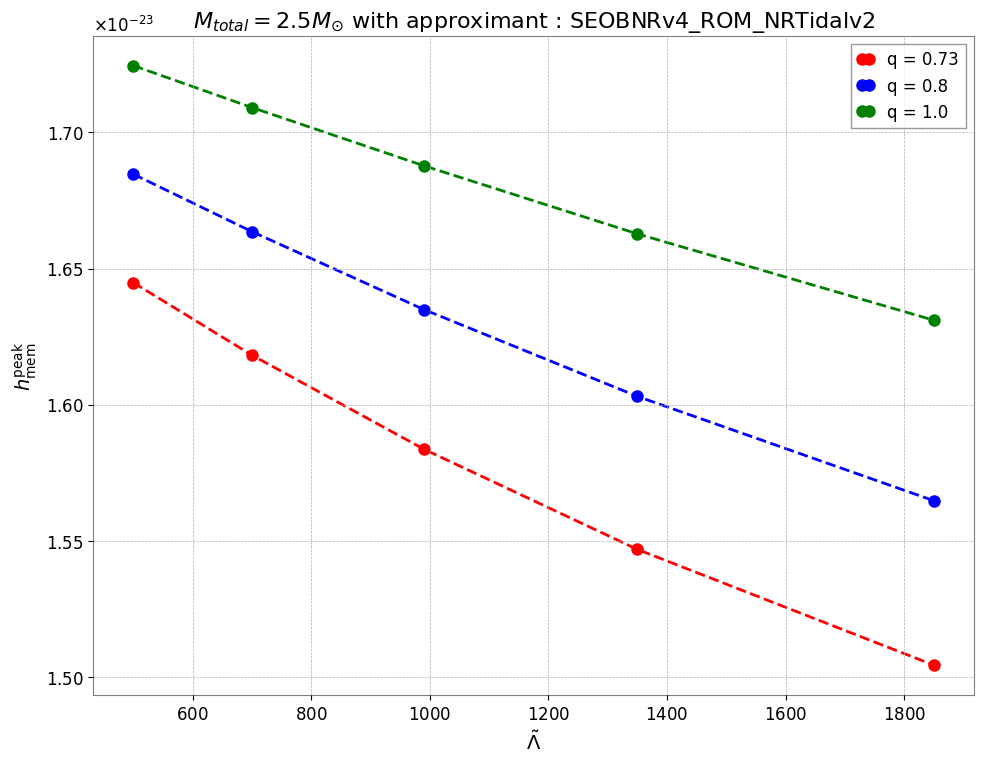

Value of lambda1: 1116.5210939746835, lambda2: 231.46281629041997 for q=0.73 and lam_tilde=500
Value of lambda1: 1563.129531564557, lambda2: 324.04794280658797 for q=0.73 and lam_tilde=700
Value of lambda1: 2210.711766069873, lambda2: 458.29637625503153 for q=0.73 and lam_tilde=990
Value of lambda1: 3014.606953731646, lambda2: 624.9496039841341 for q=0.73 and lam_tilde=1350
Value of lambda1: 4131.128047706329, lambda2: 856.4124202745539 for q=0.73 and lam_tilde=1850
Value of lambda1: 880.6925608699481, lambda2: 288.58533834586467 for q=0.8 and lam_tilde=500
Value of lambda1: 1232.9695852179275, lambda2: 404.0194736842106 for q=0.8 and lam_tilde=700
Value of lambda1: 1743.7712705224974, lambda2: 571.398969924812 for q=0.8 and lam_tilde=990
Value of lambda1: 2377.86991434886, lambda2: 779.1804135338347 for q=0.8 and lam_tilde=1350
Value of lambda1: 3258.5624752188082, lambda2: 1067.7657518796993 for q=0.8 and lam_tilde=1850
Value of lambda1: 500.0, lambda2: 500.0 for q=1.0 and lam_tilde=

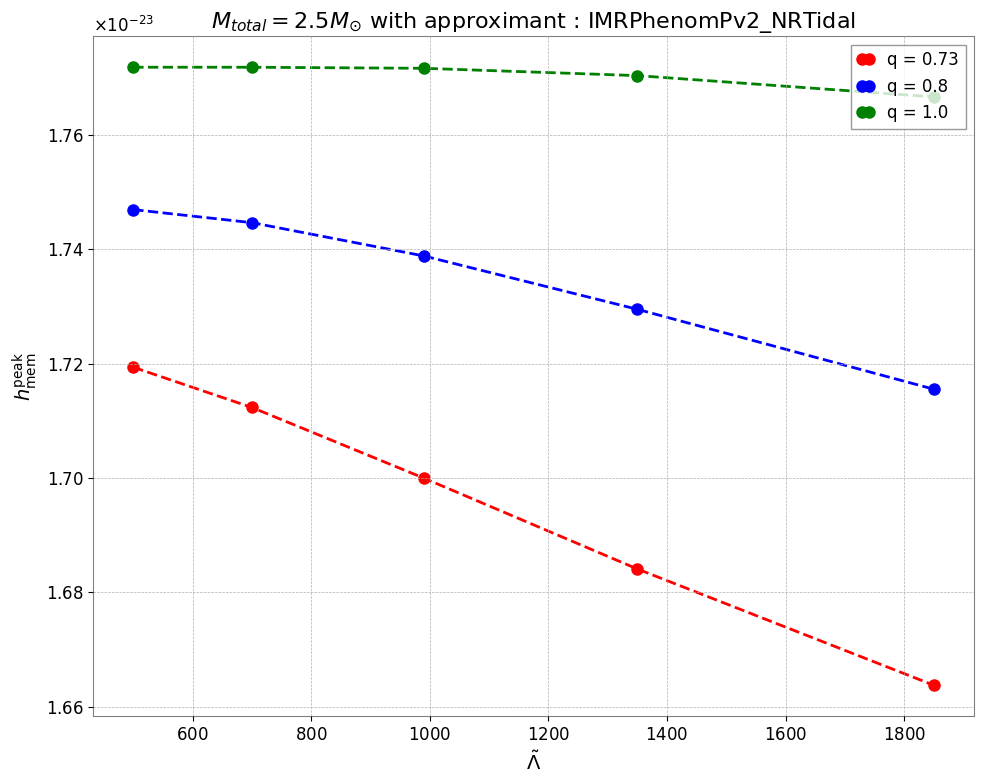

Value of lambda1: 1116.5210939746835, lambda2: 231.46281629041997 for q=0.73 and lam_tilde=500
Value of lambda1: 1563.129531564557, lambda2: 324.04794280658797 for q=0.73 and lam_tilde=700
Value of lambda1: 2210.711766069873, lambda2: 458.29637625503153 for q=0.73 and lam_tilde=990
Value of lambda1: 3014.606953731646, lambda2: 624.9496039841341 for q=0.73 and lam_tilde=1350
Value of lambda1: 4131.128047706329, lambda2: 856.4124202745539 for q=0.73 and lam_tilde=1850
Value of lambda1: 880.6925608699481, lambda2: 288.58533834586467 for q=0.8 and lam_tilde=500
Value of lambda1: 1232.9695852179275, lambda2: 404.0194736842106 for q=0.8 and lam_tilde=700
Value of lambda1: 1743.7712705224974, lambda2: 571.398969924812 for q=0.8 and lam_tilde=990
Value of lambda1: 2377.86991434886, lambda2: 779.1804135338347 for q=0.8 and lam_tilde=1350
Value of lambda1: 3258.5624752188082, lambda2: 1067.7657518796993 for q=0.8 and lam_tilde=1850
Value of lambda1: 500.0, lambda2: 500.0 for q=1.0 and lam_tilde=

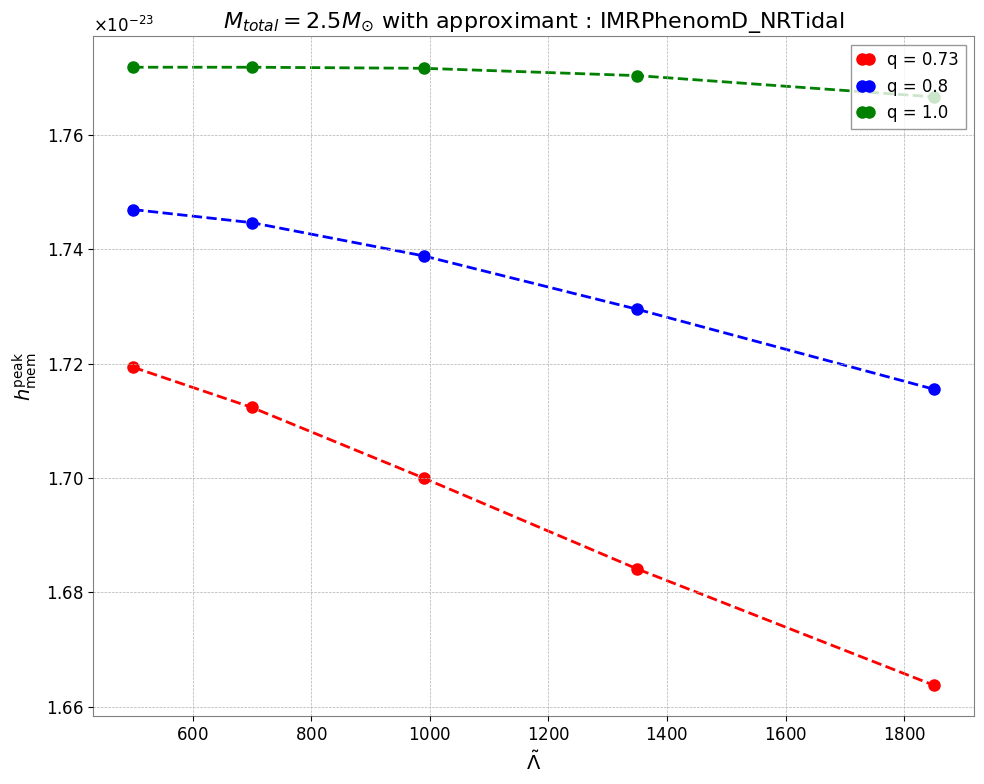

Value of lambda1: 1116.5210939746835, lambda2: 231.46281629041997 for q=0.73 and lam_tilde=500
Value of lambda1: 1563.129531564557, lambda2: 324.04794280658797 for q=0.73 and lam_tilde=700
Value of lambda1: 2210.711766069873, lambda2: 458.29637625503153 for q=0.73 and lam_tilde=990
Value of lambda1: 3014.606953731646, lambda2: 624.9496039841341 for q=0.73 and lam_tilde=1350
Value of lambda1: 4131.128047706329, lambda2: 856.4124202745539 for q=0.73 and lam_tilde=1850
Value of lambda1: 880.6925608699481, lambda2: 288.58533834586467 for q=0.8 and lam_tilde=500
Value of lambda1: 1232.9695852179275, lambda2: 404.0194736842106 for q=0.8 and lam_tilde=700
Value of lambda1: 1743.7712705224974, lambda2: 571.398969924812 for q=0.8 and lam_tilde=990
Value of lambda1: 2377.86991434886, lambda2: 779.1804135338347 for q=0.8 and lam_tilde=1350
Value of lambda1: 3258.5624752188082, lambda2: 1067.7657518796993 for q=0.8 and lam_tilde=1850
Value of lambda1: 500.0, lambda2: 500.0 for q=1.0 and lam_tilde=

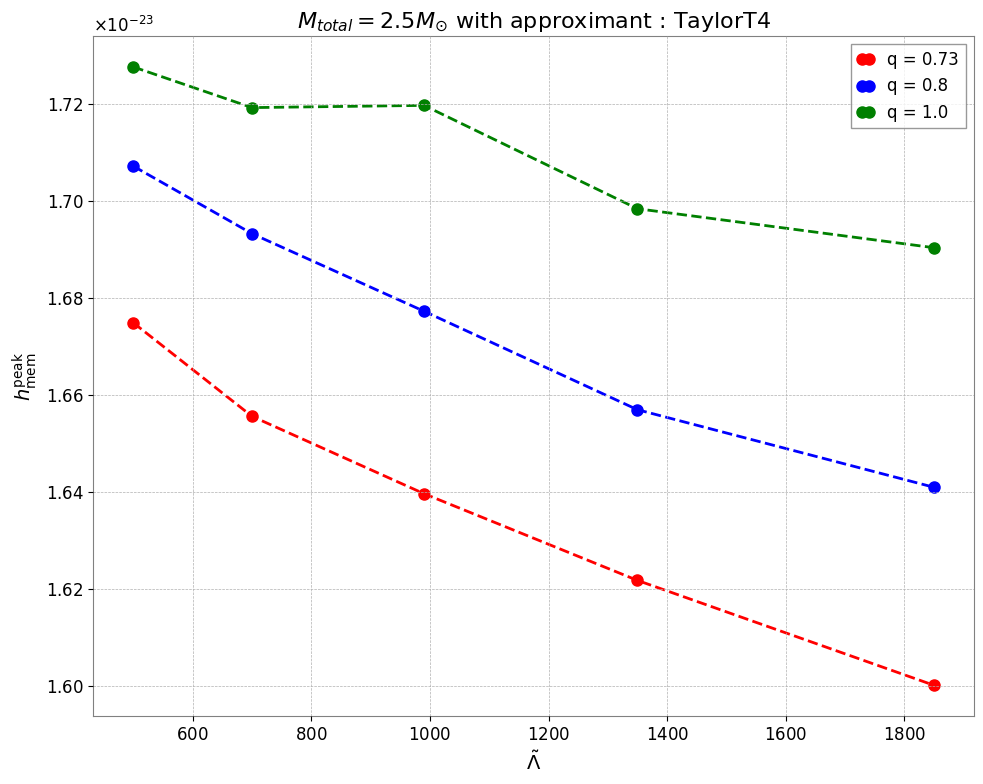

Value of lambda1: 1116.5210939746835, lambda2: 231.46281629041997 for q=0.73 and lam_tilde=500
Value of lambda1: 1563.129531564557, lambda2: 324.04794280658797 for q=0.73 and lam_tilde=700
Value of lambda1: 2210.711766069873, lambda2: 458.29637625503153 for q=0.73 and lam_tilde=990
Value of lambda1: 3014.606953731646, lambda2: 624.9496039841341 for q=0.73 and lam_tilde=1350
Value of lambda1: 4131.128047706329, lambda2: 856.4124202745539 for q=0.73 and lam_tilde=1850
Value of lambda1: 880.6925608699481, lambda2: 288.58533834586467 for q=0.8 and lam_tilde=500
Value of lambda1: 1232.9695852179275, lambda2: 404.0194736842106 for q=0.8 and lam_tilde=700
Value of lambda1: 1743.7712705224974, lambda2: 571.398969924812 for q=0.8 and lam_tilde=990
Value of lambda1: 2377.86991434886, lambda2: 779.1804135338347 for q=0.8 and lam_tilde=1350
Value of lambda1: 3258.5624752188082, lambda2: 1067.7657518796993 for q=0.8 and lam_tilde=1850
Value of lambda1: 500.0, lambda2: 500.0 for q=1.0 and lam_tilde=

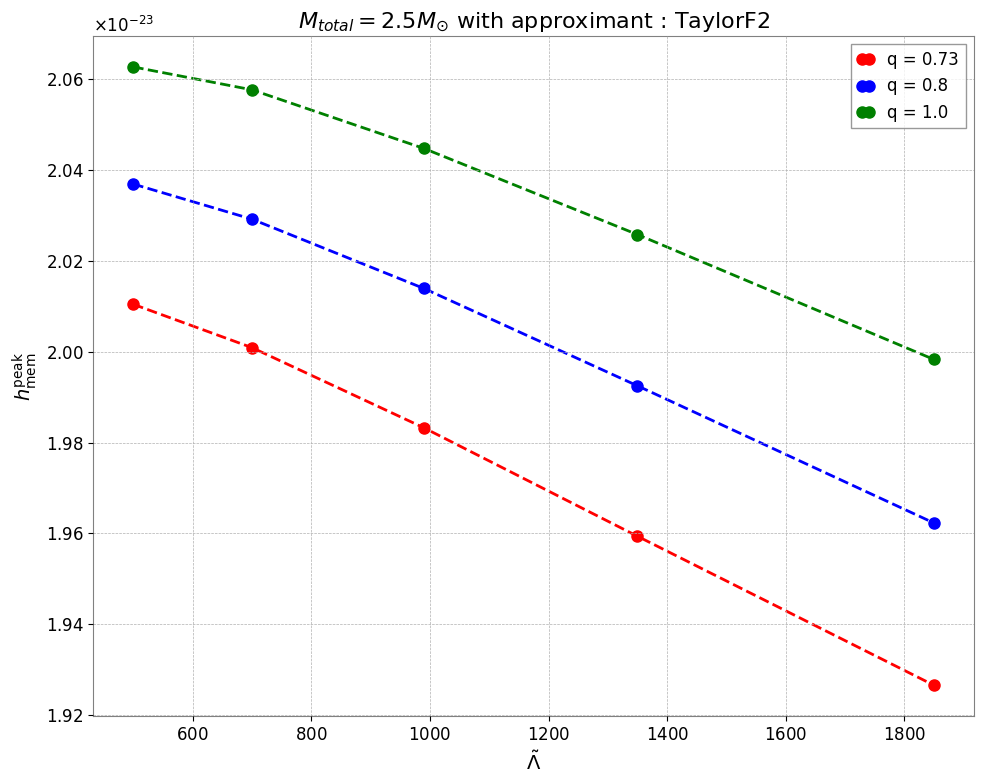

In [21]:
# Paramètres utilisées
lambda_tilde = np.array([500, 700, 990, 1350, 1850])  # à refined avec modèles d'EOS
m_tot = 2.5
d = 100  # Mpc
q_array = np.array([0.73, 0.8, 1])
incl = np.pi/2  
approx = ["SEOBNRv4_ROM_NRTidalv2", "IMRPhenomPv2_NRTidal","IMRPhenomD_NRTidal",
          "TaylorT4", "TaylorF2"]
colors = ['red', 'blue', 'green']

for approximant in approx:
    try: 
        fig, ax = plt.subplots(figsize=(10, 8))
        for (q, color) in zip(q_array, colors):
            h_mem_max_values = []
            for lam in lambda_tilde:
                _, hmem = generate_h_mem(m_tot, lam, q, d, incl, extension_time=0.2, approximant=approximant)
                hmem_max = np.max(np.abs(hmem))
                h_mem_max_values.append(hmem_max)
            ax.plot(lambda_tilde, h_mem_max_values, color=color, marker='o', linestyle='--', linewidth=2, markersize=8, label=f'q = {q}')


        ax.set_xlabel(r'$\tilde{\Lambda}$', fontsize=14)
        ax.set_ylabel(r'$h^{\mathrm{peak}}_{\mathrm{mem}}$', fontsize=14)
        ax.set_title(rf'$M_{{total}} = {m_tot}M_{{\odot}}$ with approximant : {approximant}', fontsize=16)
        ax.legend(loc='upper right', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        #ax.set_ylim(0.6*10**(-23), 1.85*10**(-23)) # ylim idem que l'article 
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error with approximant {approximant}: {e}")

In [ ]:
# Paramètres utilisées
lambda_tilde = np.array([200,410, 600, 850, 1190])  # à refined avec modèles d'EOS
m_tot = 2.7
d = 100  # Mpc
q_array = np.array([0.73, 0.75, 0.76, 0.8, 0.86, 1])
incl = np.pi/2  
approx = ["SEOBNRv4_ROM_NRTidalv2", "IMRPhenomPv2_NRTidal","IMRPhenomD_NRTidal",
          "TaylorT4", "TaylorF2"]
colors = ['red', 'pink', 'brown' , 'blue', 'black', 'green']

for approximant in approx:
    try: 
        fig, ax = plt.subplots(figsize=(10, 8))
        for (q, color) in zip(q_array, colors):
            h_mem_max_values = []
            for lam in lambda_tilde:
                _, hmem = generate_h_mem(m_tot, lam, q, d, incl, extension_time=0.2, approximant=approximant)
                hmem_max = np.max(np.abs(hmem))
                h_mem_max_values.append(hmem_max)
            ax.plot(lambda_tilde, h_mem_max_values, color=color, marker='o', linestyle='--', linewidth=2, markersize=8, label=f'q = {q}')


        ax.set_xlabel(r'$\tilde{\Lambda}$', fontsize=14)
        ax.set_ylabel(r'$h^{\mathrm{peak}}_{\mathrm{mem}}$', fontsize=14)
        ax.set_title(rf'$M_{{total}} = {m_tot}M_{{\odot}}$ with approximant : {approximant}', fontsize=16)
        ax.legend(loc='upper right', fontsize=12, ncol=2)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        #ax.set_ylim(0.6*10**(-23), 1.85*10**(-23)) # ylim idem que l'article 
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error with approximant {approximant}: {e}")

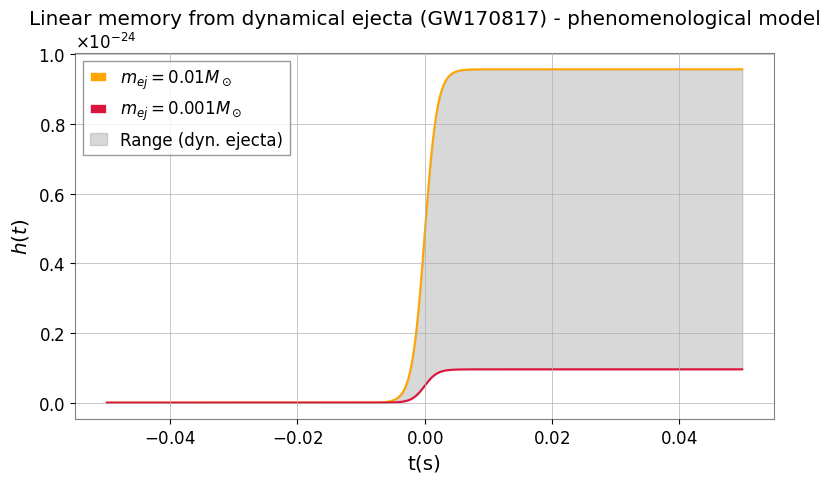

In [22]:
from lal import MSUN_SI, PC_SI, C_SI, G_SI
# Paramètres très généraux pour l'éjecta !dynamique! de GW170817
m_ej_min = 1e-3 * MSUN_SI  # kg
m_ej_max = 1e-2 * MSUN_SI  # kg
v_ej = 0.2 * C_SI           # m/s
r = 40 * 1e6 * PC_SI        # m
tau = 1e-3              # s - temps d'éjection de la matière - de l'ordre de  << qq ms

# Calcul deltah min et max
delta_h_min = (2 * G_SI * m_ej_min * v_ej**2) / (C_SI**4 * r)
delta_h_max = (2 * G_SI * m_ej_max * v_ej**2) / (C_SI**4 * r)

t = np.linspace(-0.05, 0.05, 1000)

# Forme temporelle
h_min = delta_h_min / (1 + np.exp(-t / tau))
h_max = delta_h_max / (1 + np.exp(-t / tau))

plt.figure(figsize=(8,5))
plt.plot(t, h_max, label=rf"$m_{{ej}} = {m_ej_max/ MSUN_SI}M_\odot$", color='orange')
plt.plot(t, h_min, label=rf"$m_{{ej}} = {m_ej_min/ MSUN_SI}M_\odot$", color='crimson')
plt.fill_between(t, h_min, h_max, color='gray', alpha=0.3, label="Range (dyn. ejecta)")
plt.xlabel("t(s)")
plt.ylabel(r"$h(t)$")
plt.title("Linear memory from dynamical ejecta (GW170817) - phenomenological model")
plt.legend()
plt.tight_layout()
plt.show()

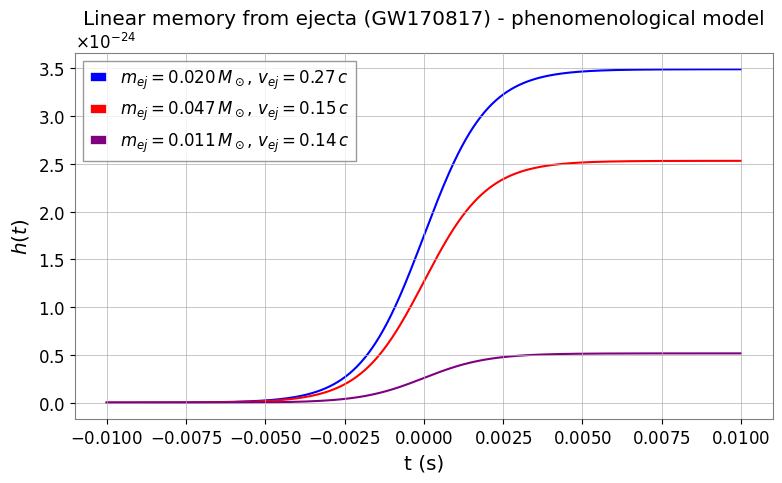

In [23]:
from lal import MSUN_SI, PC_SI, C_SI, G_SI
# paramètres de GW170817 (Villar et al. 2017) - venant de thèse Marion pour GW170817 pour composantes blue / red / purple de l'éjecta totale
M_ej = np.array([0.02, 0.047, 0.011])
M_ej *= MSUN_SI          # convertir en kg
v_ej_values = np.array([0.27, 0.15, 0.14])
v_ej_values *= C_SI      # convertir en m/s
r = 40 * PC_SI * 1e6     # distance en mètres (40 Mpc)
colors = ['blue', 'red', 'purple']

tau = 0.001        # temps caractéristique en secondes - à ajuster ! (essayer de le fit sur la simulation ?)

# calcul de delta_h 
delta_h = 2 * G_SI / (C_SI**4 * r) * M_ej * v_ej_values**2  # tableau de longueur 3

# Grille temporelle
t = np.linspace(-0.01, 0.01, 1000)

# h(t) pour chaque composante 
h_lin = delta_h[None, :] / (1 + np.exp(-t[:, None] / tau))

# Plot
plt.figure(figsize=(8, 5))

for i, (m_ej, v_ej) in enumerate(zip(M_ej, v_ej_values)):
    plt.plot(t, h_lin[:, i],
             label=f"$m_{{ej}}={m_ej/MSUN_SI:.3f}\\,M_\odot$, $v_{{ej}}={v_ej/C_SI:.2f}\\,c$",
             color=colors[i])

plt.xlabel("t (s)")
plt.ylabel(r"$h(t)$")
plt.title("Linear memory from ejecta (GW170817) - phenomenological model")
plt.legend()
plt.tight_layout()
plt.show()